# Data Preprocessing

In [ ]:
# Import libraries
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import sklearn as skl
import string

In [ ]:
# Define functions
def weighted_mean(column1):
    """
    Returns the expected value of a column in a dataframe.
    The expected value is taken from probability. Value * Probaility.
    """
    series = pd.Series(column1)
    expected = 0
    unique = column1.unique()
    for i in unique:
        prob = probability(i, column1)
        expected += prob*i
    return round(expected)

def probability(value, series):
    """
    Returns the probability of a value in a series.
    """
    series = pd.Series(series)
    total_amount = series.count()
    int_series = series.loc[series == value]
    is_size = int_series.count()
    prob = is_size/total_amount
    return prob

def map_year_to_period(year):
    if year < 1980:
        return "Before 1980"
    elif 1980 <= year < 1990:
        return "1980s"
    elif 1990 <= year < 2000:
        return "1990s"
    elif 2000 <= year < 2010:
        return "2000s"
    elif 2010 <= year < 2020:
        return "2010s"

    else:
        return "After 2020"

In [ ]:
# Variable Set Up
CURR_YR = 2024

# Read csv files
books_df = pd.read_csv("BX-Books.csv")
users_df = pd.read_csv("BX-Users.csv")
ratings_df = pd.read_csv("BX-Ratings.csv")

# Assigning variables to operate on users_df
u_country = users_df["User-Country"]
u_age = users_df["User-Age"]

# Assigning variables to operate on books_df
b_title = books_df["Book-Title"]
b_yr = books_df["Year-Of-Publication"]
b_pub = books_df["Book-Publisher"]

In [ ]:
# -----------------------------------------------------------------------------
# Clean Up formatting issues in users
users_df["User-Age"] = u_age.str.extract('(^[\d]{1,})')
users_df["User-Country"] = u_country.str.extract(r'(\w+)')

# Clean up missing data from BX-Users

# Add data to Age
no_age_df = users_df.loc[users_df["User-Age"].isnull()] # DF w/o age.
yes_age_df = users_df.loc[(users_df["User-Age"].isnull() == False)] # DF w/ age
u_age_exp = int(weighted_mean(yes_age_df["User-Age"].astype(int)))

unique_country = u_country.unique() # Find Unique Countries

# Run through all unique countries and assign an age to user.
  # Have chosen to separate by country as city and State may be too narrow
  # Have chosen 100 as the minimum bench mark for enough age data
  # If not more than 100 valid data points it will take the global expected age.
for i in unique_country:
    country_df = users_df.loc[u_country == i]
    y_age = country_df.loc[(country_df["User-Age"].isnull() == False)]
    if ((y_age["User-Age"].count()) >= 100):
        y_age_mean = int(weighted_mean(y_age["User-Age"].astype(int)))
        users_df.loc[(u_country == i) &
                     ((u_age == 0) | u_age.isnull()),
                     "User-Age"
                     ] = y_age_mean
    else:
        users_df.loc[(u_country == i) &
                     ((u_age == 0) | u_age.isnull()),
                     "User-Age"
                     ] = u_age_exp

# Change all values to integers
users_df["User-Age"] = users_df["User-Age"].astype(int)
# -----------------------------------------------------------------------------
# Clean up classifications for Publisher. Combine some of the similar ones.
pub_unique_dict = {"Book-Publisher": b_pub.unique()}
pub_unique_df = pd.DataFrame(data = pub_unique_dict)
pub_unique = pub_unique_df["Book-Publisher"]
split_pub = pub_unique.str.split()

pub_unique_df["Len-Pub-Unique"] = split_pub.apply(len)
one_word_pub_df = pub_unique_df.loc[pub_unique_df["Len-Pub-Unique"] == 1]
one_word_pub = one_word_pub_df["Book-Publisher"]

for i in one_word_pub:
    has_word_lst = [w for w in b_pub.unique() if i in w]
    books_df.loc[books_df["Book-Publisher"].isin(has_word_lst),
                      "Book-Publisher"] = i

# Clean Up missing data issues in BX-Books

# High Years are 2030. Most likely 2003 As years should range from 1900-2024.
books_df.loc[b_yr > CURR_YR, 'Year-Of-Publication'] = 2003

# Low Values are books without years.
# Chosen to use Publishers as the reference point. If there is no non-zero
# year for the publisher, the global expected value is taken.

# All years are above 1920 except for those that are 0.
b_yr_l = books_df.loc[b_yr == 0]
byl_pub = b_yr_l["Book-Publisher"]

byl_unique_pub = byl_pub.unique() # Find all the unique publishers in b_yr_l

b_yr_non_zero = books_df.loc[b_yr != 0] # non-zero years
# Find the expected year for the publishers who have no years.
b_yr_exp = weighted_mean(b_yr_non_zero["Year-Of-Publication"])

# Run through all unique publishers and assign
for i in byl_unique_pub:
    pub_df = books_df.loc[b_pub == i]
    non_zero_data = pub_df.loc[pub_df["Year-Of-Publication"] != 0]
    if ((non_zero_data["Year-Of-Publication"].count())!= 0 ):
        nzd_mean = weighted_mean(non_zero_data["Year-Of-Publication"])
        books_df.loc[(b_pub == i) &
                 (b_yr == 0),
                 "Year-Of-Publication"
                ] = nzd_mean
    else:
        books_df.loc[(b_pub == i) &
                 (b_yr == 0),
                 "Year-Of-Publication"
                ] = b_yr_exp

# Standardise Author Names - All Lowercase
books_df["Book-Author"] = books_df["Book-Author"].str.lower()


In [ ]:
 Merges all dataframes together.
merged_data_df = pd.merge(ratings_df, books_df, on = "ISBN", how="inner")
merged_data_df = pd.merge(merged_data_df, users_df, on = "User-ID", how="inner")

# Visualise the data

# Modelling

Accuracy: 0.6052212671123846
Precision: 0.5399295574332733
Recall: 0.6052212671123846


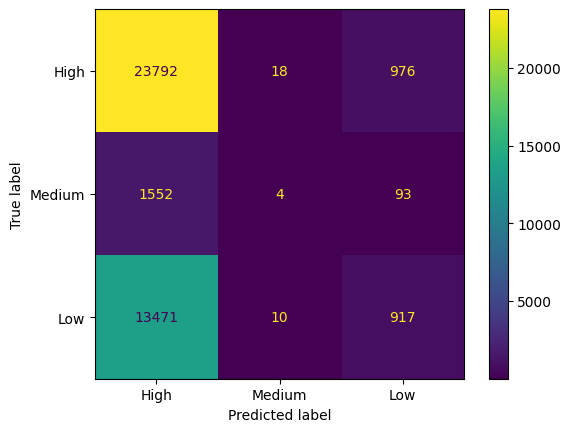

RMSE: 1.2067309735173208
R^2 Score: -0.6272285556542612
MSE: 1.4561996424460608
MAE: 0.7485857027404306


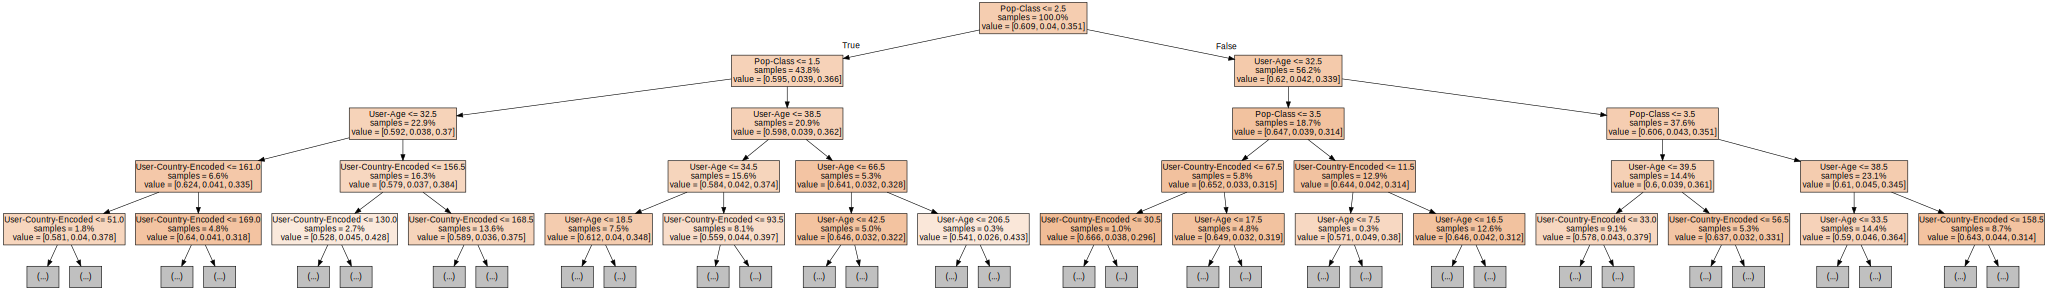

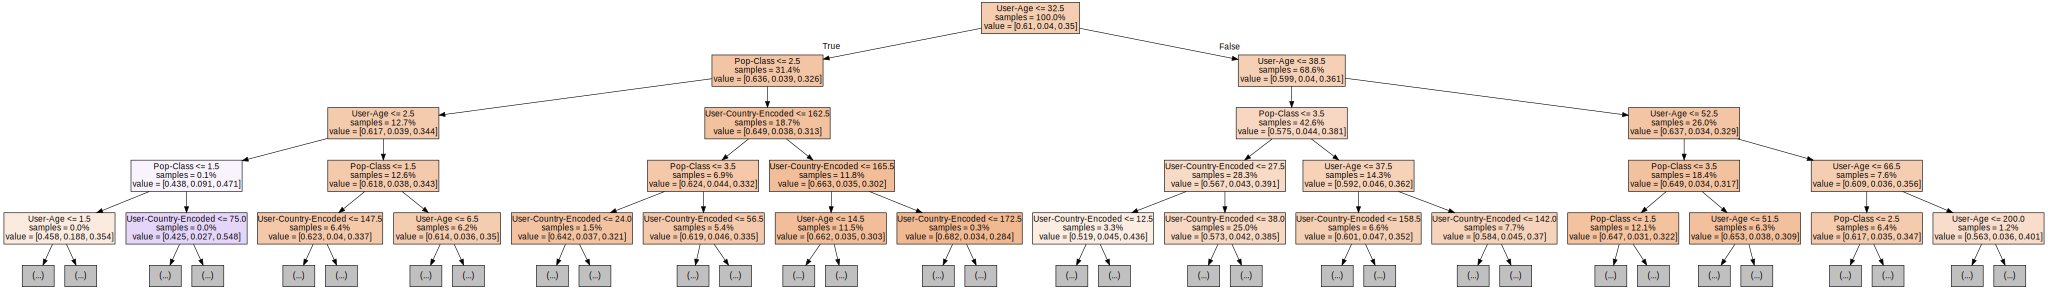

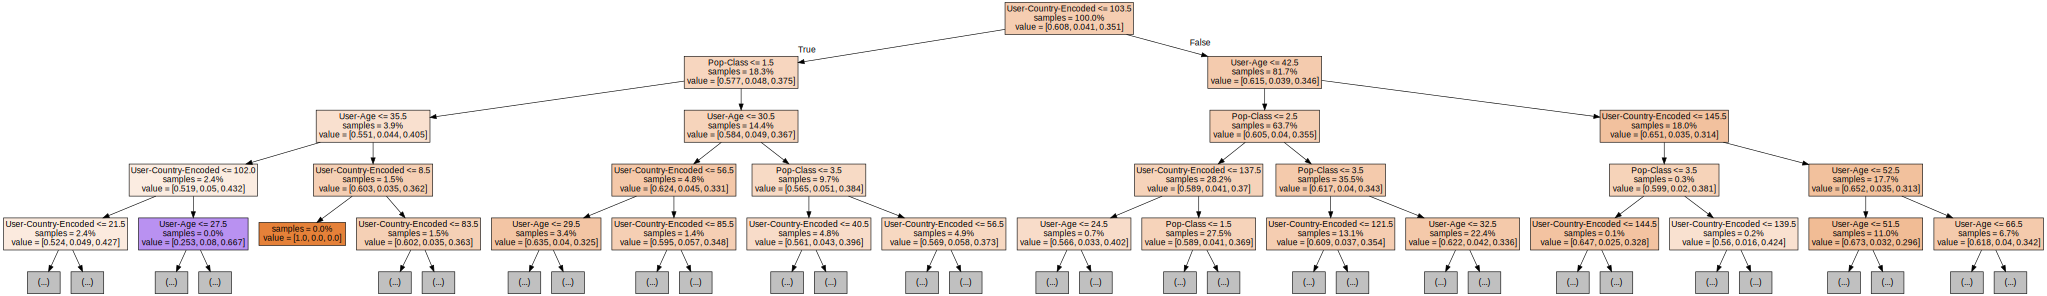

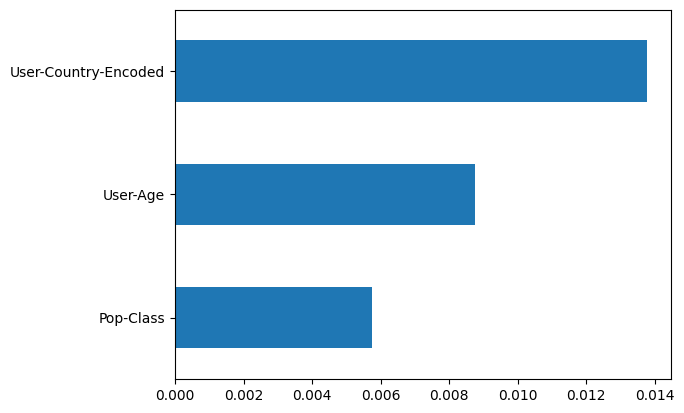

In [ ]:
# Random Forest Attempt --- https://www.datacamp.com/tutorial/random-forests-classifier-python

# Data Processing
import pandas as pd
import numpy as np

# Modelling
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint
from sklearn.feature_selection import mutual_info_classif

# Tree Visualisation
from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz
from sklearn.preprocessing import LabelEncoder
merged_data_df = pd.DataFrame(merged_data_df)
import scipy.stats
np.corrcoef(merged_data_df["Book-Rating"], merged_data_df["Pop-Class"])
pop_class_corr = scipy.stats.pearsonr(merged_data_df["Book-Rating"], merged_data_df["Pop-Class"])
# -----------------------------------------------------------------------------
# -----------------------------------------------------------------------------
# Pre-Processing specific for model.
label_encoder = LabelEncoder()
merged_data_df['Publication-Period'] = merged_data_df['Year-Of-Publication'].apply(map_year_to_period)
merged_data_df['Publication-Period'] = label_encoder.fit_transform(merged_data_df['Publication-Period'])

# Turn Publishers into something usable by Random Forest.

m_b_pub = merged_data_df["Book-Publisher"]
merged_data_df["Pub-Encoded"] = label_encoder.fit_transform(m_b_pub)

# -----------------------------------
# Find the more popular half of publishers based on reader numbers.
top_half_pub = []
# Get the value_counts of each publisher. Break them down into arrays of values
# and indexes.
sorted_pub = merged_data_df["Book-Publisher"].value_counts().index
pub_read = merged_data_df["Book-Publisher"].value_counts().values

# Run through the publishers and
# create a list of the top half based on reader count
for i in range(0, len(sorted_pub)):
    pub_pop = (sum(pub_read[0: i])/merged_data_df.shape[0])
    if (pub_pop >= 0.5):
        break
    top_half_pub.append(sorted_pub[i])
m_b_pub = merged_data_df["Book-Publisher"]
merged_data_df["In-Most-Read-Pub"] = m_b_pub.isin(top_half_pub)

# -----------------------------------
# Run through the publishers and create bins based on reader count.
# Keeps each bin less than 20% of the readership except for the last bin.
i=0
pop_class = [1, 2, 3, 4, 5]
min = 0 # Current minimum for hte indexing of the publishers.
a = 1 # Current index.
curr_prog = 0
while (curr_prog < 1):
    curr_lst = []
    while (a <= len(pub_read)): # Guard for indexing.
        pub_pop = (sum(pub_read[min: a-1])/merged_data_df.shape[0])
        if (i == 3): # Final Bin.
            curr_lst = sorted_pub[min: len(pub_read)]
            merged_data_df.loc[merged_data_df["Book-Publisher"].isin(curr_lst),
                               "Pop-Class"] = pop_class[i]
            curr_prog = 1 # Terminate the loop.
            break #Exit current loop if condition is met. Do not run other lines

        if (pub_pop > 0.20): # Creating bins.
            curr_lst = sorted_pub[min: a-1]
            merged_data_df.loc[merged_data_df["Book-Publisher"].isin(curr_lst),
                               "Pop-Class"] = pop_class[i]
            i += 1
            min = a-1
            curr_prog += pub_pop # Update current progress so it terminates.
            break # Exit current loop if condition is met.
        a+=1

# -----------------------------------
# Binning the Ratings - Categorising them based on programmer perception.
merged_data_df.loc[merged_data_df["Book-Rating"] <= 4,
                  "Book-Rating-Class"] = "Low"
merged_data_df.loc[(merged_data_df["Book-Rating"] >= 5) &
                   (merged_data_df["Book-Rating"] <= 7),
                   "Book-Rating-Class"] = "Medium"
merged_data_df.loc[(merged_data_df["Book-Rating"] >= 8) &
                   (merged_data_df["Book-Rating"] <= 10),
                   "Book-Rating-Class"] = "High"
merged_data_df['User-Country-Encoded'] = label_encoder.fit_transform(merged_data_df['User-Country'])
# -----------------------------------------------------------------------------
# -----------------------------------------------------------------------------
df = pd.DataFrame()
# Model with Random Forest
X = merged_data_df[["Pop-Class", "User-Age", "User-Country-Encoded", "Year-Of-Publication"]]
y = merged_data_df["Book-Rating-Class"]

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)
rf = RandomForestClassifier()

rf.fit(X_train, y_train) # Train the model
y_pred = rf.predict(X_test) # Predict with model

# Test to see how accuract via different measures.
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average ="weighted")
recall = recall_score(y_test, y_pred, average = "weighted")
a_lst = []
a_lst.append(accuracy)
a_lst.append(precision)
a_lst.append(recall)
df["3 Bin Model"] = a_lst


confusion_matrix_1 = confusion_matrix(y_test, y_pred)

cm_display = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix_1, display_labels = ["High", "Medium", "Low"])

cm_display.plot()
plt.show()

rand_forest_dict = {"Randforest":[accuracy, precision, recall, rmse, r2,
                                  mse, mae]}
rand_forest_df = pd.DataFrame(rand_forest_dict)


# Export the first three decision trees from the forest
for i in range(0, 3):
    tree = rf.estimators_[i]
    dot_data = export_graphviz(tree,
                               feature_names=X_train.columns,
                               filled=True,
                               max_depth = 4,
                               impurity=False,
                               proportion=True)
    graph = graphviz.Source(dot_data)
    display(graph)

importances = mutual_info_classif(X, y)
feat_importance = pd.Series(importances, X.columns[0:len(X.columns)])
feat_importance.plot(kind = "barh")
plt.show()

# Binning the Ratings - Categorising them based on programmer perception.
merged_data_df.loc[merged_data_df["Book-Rating"] <= 6,
                  "Book-Rating-Class"] = "Low"
merged_data_df.loc[(merged_data_df["Book-Rating"] >= 7) &
                   (merged_data_df["Book-Rating"] <= 10),
                   "Book-Rating-Class"] = "High"
merged_data_df['User-Country-Encoded'] = label_encoder.fit_transform(merged_data_df['User-Country'])
# -----------------------------------------------------------------------------
# -----------------------------------------------------------------------------
# Model with Random Forest
X = merged_data_df[["Pop-Class", "User-Age", "User-Country-Encoded", "Year-Of-Publication"]]
y = merged_data_df["Book-Rating-Class"]

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)
rf = RandomForestClassifier()

rf.fit(X_train, y_train) # Train the model
y_pred = rf.predict(X_test) # Predict with model

# Test to see how accuract via different measures.
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average ="weighted")
recall = recall_score(y_test, y_pred, average = "weighted")
b_lst = []
b_lst.append(accuracy)
b_lst.append(precision)
b_lst.append(recall)
df["2 Bin Model"] = b_lst

confusion_matrix_2 = confusion_matrix(y_test, y_pred)

cm_display = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix_2, display_labels = ["High", "Low"])

cm_display.plot()
plt.show()

df["Evaluation Metrics"] = ["Accuracy", "Precision", "Recall"]
df.set_index("Evaluation Metrics")
display(df)

Linear Regression RMSE: 1.7857088425545296
Linear Regression R^2 Score: 0.0007094211587113097
Linear Regression MSE: 3.1887560703774374
Linear Regression MAE: 1.4211189305601122
Linear Regression RMSE: 1.78570472508233
Linear Regression R^2 Score: 0.0007140294647642875
Linear Regression MSE: 3.1887413651813596
Linear Regression MAE: 1.4204411043786669
Classification Accuracy: 0.6091886464379301
Classification Report:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

        High       0.61      1.00      0.76     24875
         Low       0.00      0.00      0.00      5626
      Medium       0.00      0.00      0.00     10332

    accuracy                           0.61     40833
   macro avg       0.20      0.33      0.25     40833
weighted avg       0.37      0.61      0.46     40833



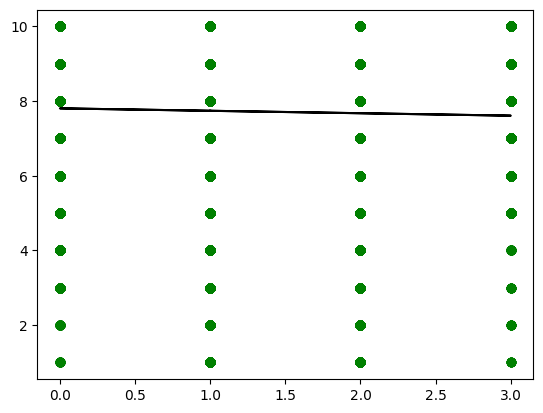

In [ ]:
#Legolas Linear Regression
# Linear Regression for Publication-Period

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_squared_error, mean_absolute_error

import pandas as pd

label_encoder = LabelEncoder()

merged_data_df['Publication-Period'] = label_encoder.fit_transform(merged_data_df['Publication-Period'])

X = merged_data_df[["Publication-Period"]]
y = merged_data_df['Book-Rating']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

linear_reg = LinearRegression()

linear_reg.fit(X_train, y_train)

y_pred = linear_reg.predict(X_test)

rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print("Linear Regression RMSE:", rmse)
print("Linear Regression R^2 Score:", r2)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print("Linear Regression MSE:", mse)
print("Linear Regression MAE:", mae)
# seems like the rmse and r^2 's results are not so well.

plt.scatter(X_train, y_train,color='g')
plt.plot(X_test, y_pred,color='k')

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_squared_error, mean_absolute_error

import pandas as pd

label_encoder = LabelEncoder()

merged_data_df['User-Country-Encoded'] = label_encoder.fit_transform(merged_data_df['User-Country'])

X = merged_data_df[['User-Country-Encoded']]
y = merged_data_df['Book-Rating']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

linear_reg = LinearRegression()

linear_reg.fit(X_train, y_train)

y_pred = linear_reg.predict(X_test)

rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print("Linear Regression RMSE:", rmse)
print("Linear Regression R^2 Score:", r2)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print("Linear Regression MSE:", mse)
print("Linear Regression MAE:", mae)

#classfication for User-Country-Encoded ,Publication-Period and rating
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder

# Encode User-Country column into numerical form
label_encoder_country = LabelEncoder()
merged_data_df['User-Country-Encoded'] = label_encoder_country.fit_transform(merged_data_df['User-Country'])

# Define features
X = merged_data_df[['Publication-Period', 'User-Country-Encoded']]
# Define target variable
y = merged_data_df['Book-Rating']

# Define the categories for rating classification
def classify_rating(rating):
    if rating <= 5:
        return 'Low'
    elif rating <= 7:
        return 'Medium'
    else:
        return 'High'

# Create a new target variable with rating categories
y_classification = y.apply(classify_rating)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_classification, test_size=0.2, random_state=42)

# Initialize and train the logistic regression model
logistic_reg = LogisticRegression(max_iter=1000)
logistic_reg.fit(X_train, y_train)

# Predict rating categories for test set
y_pred = logistic_reg.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)

# Print accuracy
print("Classification Accuracy:", accuracy)

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

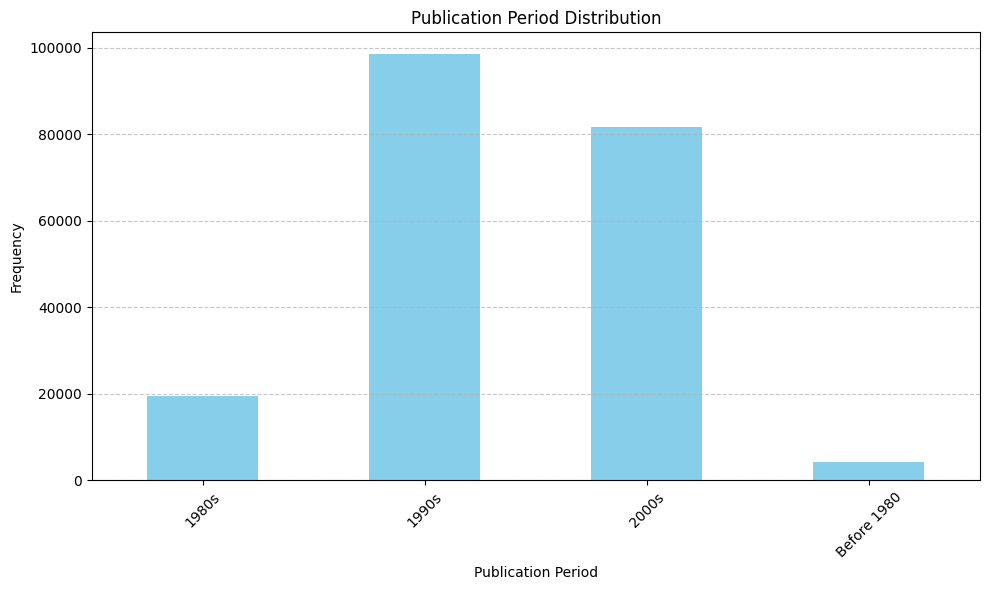

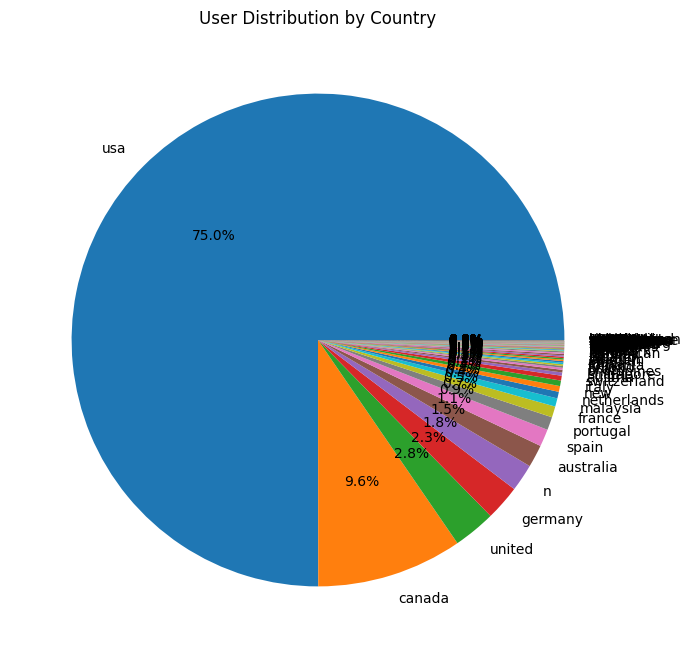

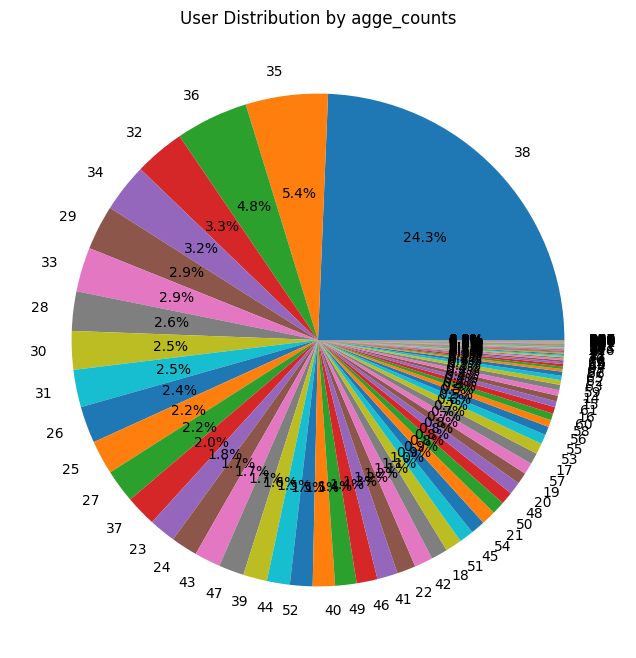

KeyboardInterrupt: 

/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 131 (\x83) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 130 (\x82) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 131 (\x83) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 130 (\x82) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


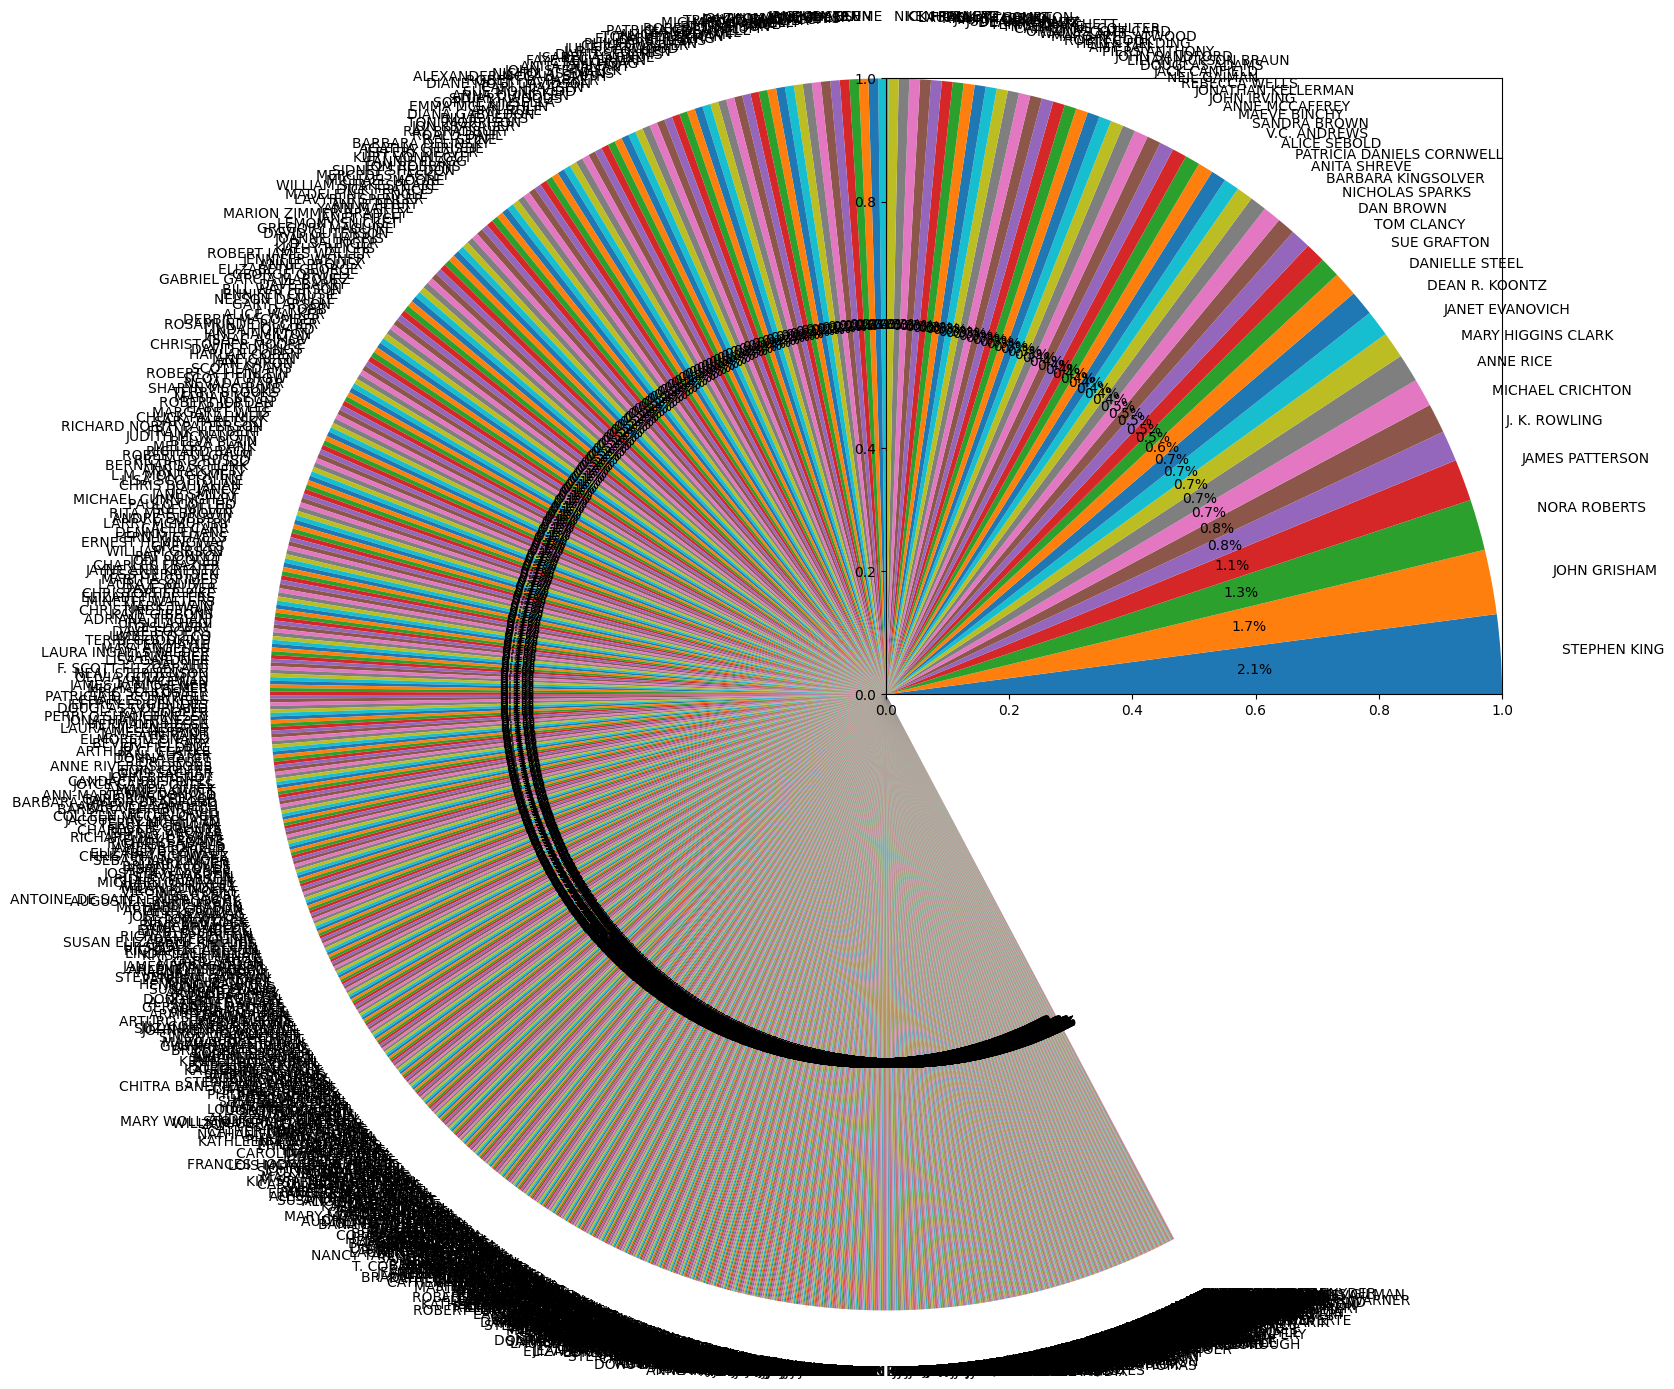

In [ ]:
merged_data_df['Publication-Period'] = merged_data_df['Year-Of-Publication'].apply(map_year_to_period)

# divide timeline from 1980 until 2010, one decade as one period, it will be easier to anlyasis between each period.
period_counts = merged_data_df['Publication-Period'].value_counts()

period_counts_sorted = period_counts.sort_index()

plt.figure(figsize=(10, 6))
period_counts_sorted.plot(kind='bar', color='skyblue')
plt.title('Publication Period Distribution')
plt.xlabel('Publication Period')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
merged_data_df

# plot distribution of country

country_list =  merged_data_df['User-Country']
country_counts = country_list.value_counts()
plt.figure(figsize=(8, 8))
plt.pie(country_counts, labels=country_counts.index, autopct='%1.1f%%')
plt.title('User Distribution by Country')
plt.show()

# it's obivous that this pie char is clear enough for us to research and there're some conutries whose occupation is too small to igonre.
# it's more accessible to choose the country which occupied more than 1%
#  these countries are usa(75%), canada(9.6%)，united (2.8%),germany(2.3%),australia(1.5%),spain(1.1%)

# plot distribution of User-Age
age_list =  merged_data_df['User-Age']
age_counts = age_list.value_counts()
plt.figure(figsize=(8, 8))
plt.pie(age_counts, labels=age_counts.index, autopct='%1.1f%%')
plt.title('User Distribution by agge_counts')
plt.show()
# it's asccessible to detect those states with countries that we have
# we can first see the influence from countries to rating, then keep on analysis the
#state which have higher occupation in countries.

# plot distribution of author
author_list =  merged_data_df['Book-Author']
author_counts = author_list.value_counts()
plt.figure(figsize=(8, 8))
plt.pie(author_counts, labels=author_counts.index, autopct='%1.1f%%')
plt.title('User Distribution by author')
plt.show()

# it's clear that it's too hard to count the occupation of each author, and there's o author whose very outstanding
# thus we can may discard this element

# plot distribution of Year-Of-Publication
time_list = merged_data_df['Year-Of-Publication']
time_counts = time_list.value_counts()
plt.figure(figsize=(10, 6))
plt.bar(time_counts.index, time_counts)
plt.title('User Distribution by Year-Of-Publication')
plt.xlabel('Year')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
# as we see in the graph the year of pulibcation shows a relative average occupation, but we should continuous to decide
# because personally researching on the year of publication is meaningless to rating

publisher_list =  merged_data_df['Book-Publisher']
publisher_counts = publisher_list.value_counts()
plt.figure(figsize=(8, 8))
plt.pie(publisher_counts, labels=publisher_counts.index, autopct='%1.1f%%')
plt.title('User Distribution by Book-Publisher')
plt.show()

# those publisher whose occupation under 2% can be simplied as others,
#we can focus onthe first 12 publishers

# plot distribution of User-State
state_list =  merged_data_df['User-State']
state_counts = state_list.value_counts()
plt.figure(figsize=(8, 8))
plt.pie(state_counts, labels=state_counts.index, autopct='%1.1f%%')
plt.title('User Distribution by state_counts')
plt.show()
# it's asccessible to detect those states with countries that we have
# we can first see the influence from countries to rating, then keep on analysis the
#state which have higher occupation in countries.

# plot distribution of User-City
city_list =  merged_data_df['User-City']
city_counts = city_list.value_counts()
plt.figure(figsize=(8, 8))
plt.pie(city_counts, labels=city_counts.index, autopct='%1.1f%%')
plt.title('User Distribution by city_counts')
plt.show()
# meaningless to keep on research because there're so many cities and there're so many blank area
# sine we can the graph of country which is easier to focus on we can discard this

country_counts = merged_data_df['User-Country'].value_counts()


country_percentages = country_counts / len(merged_data_df) * 100

selected_countries = country_percentages[country_percentages > 1]
other_countries = country_percentages[country_percentages <= 1]
other_percentage = other_countries.sum()

selected_countries['else'] = other_percentage

country_counts = merged_data_df['User-Country'].value_counts()

country_percentages = country_counts / len(merged_data_df) * 100

selected_countries = country_percentages[country_percentages > 1]
other_countries = country_percentages[country_percentages <= 1]
other_percentage = other_countries.sum()

selected_countries['其他'] = other_percentage

plt.figure(figsize=(10, 8))
plt.pie(selected_countries, labels=selected_countries.index, autopct='%1.1f%%')
plt.title('User Country Distribution')
plt.axis('equal')
plt.show()
#  we take the countirs whose occupation is larger than 1%

publisher_counts = merged_data_df['Book-Publisher'].value_counts()


publisher_percentages = publisher_counts / len(merged_data_df) * 100

selected_publishers = publisher_percentages[publisher_percentages > 1]
other_publishers = publisher_percentages[publisher_percentages <= 1]
other_percentage = other_publishers.sum()

selected_publishers['其他'] = other_percentage


plt.figure(figsize=(10, 8))
plt.pie(selected_publishers, labels=selected_publishers.index, autopct='%1.1f%%')
plt.title('Publisher Distribution')
plt.axis('equal')
plt.show()
#  we take the publishers whose number of books is larger than 1%

def map_year_to_period(year):
    if year < 1980:
        return "Before 1980"
    elif 1980 <= year < 1990:
        return "1980s"
    elif 1990 <= year < 2000:
        return "1990s"
    elif 2000 <= year < 2010:
        return "2000s"
    elif 2010 <= year < 2020:
        return "2010s"

    else:
        return "After 2020"
merged_data_df['Publication-Period'] = merged_data_df['Year-Of-Publication'].apply(map_year_to_period)

# Divide timeline from 1960 until 2010, one decade as one period, it will be easier to analyze between each period.
period_counts = merged_data_df['Publication-Period'].value_counts()

period_counts_sorted = period_counts.sort_index()
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
merged_data_df['Publication-Period-Encoded'] = label_encoder.fit_transform(merged_data_df['Publication-Period'])
numerical_features = merged_data_df.select_dtypes(include=['int64', 'float64'])

correlation_matrix = numerical_features.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of Features')
plt.show()


# Book Rating Distribution
merged_data_df["Book-Rating"].hist()
plt.show()

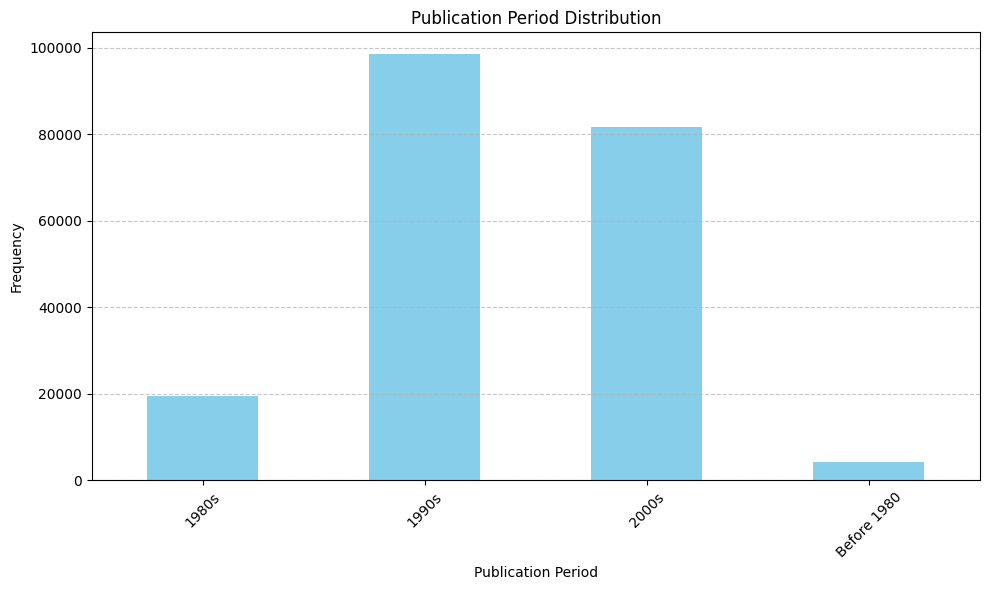

,User-ID,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Book-Publisher,User-City,User-State,User-Country,User-Age,Publication-Period
0,276744,038550120X,7,A Painted House,JOHN GRISHAM,2001,Doubleday,torrance,california,usa,38,2000s
1,11676,038550120X,10,A Painted House,JOHN GRISHAM,2001,Doubleday,NaN,n/a,n,36,2000s
2,11676,0684867621,3,The Girl Who Loved Tom Gordon : A Novel,STEPHEN KING,1999,Scribner,NaN,n/a,n,36,1990s
3,11676,3499230933,1,Adressat unbekannt.,KATHRINE KRESSMANN TAYLOR,2002,Rowohlt,NaN,n/a,n,36,2000s
4,11676,3548603203,9,Artemis Fowl.,EOIN COLFER,2003,Ullstein TB-Vlg,NaN,n/a,n,36,2000s
...,...,...,...,...,...,...,...,...,...,...,...,...
204159,259784,3442441641,10,Das GummibÃ?ÃÂ¤rchen- Orakel.,DIETMAR BITTRICH,1998,Goldmann,mainz,rheinland-pfalz,germany,32,1990s
204160,259800,3250600571,9,Oskar und die Dame in Rosa,ERIC-EMMANUEL SCHMITT,2003,Ammann,bremen,bremen,germany,25,2000s
204161,264563,3250600571,10,Oskar und die Dame in Rosa,ERIC-EMMANUEL SCHMITT,2003,Ammann,winterthur,winterthur,switzerland,33,2000s
204162,257485,0375700110,6,Half and Half: Writers on Growing Up Biracial ...,CLAUDINE C. O'HEARN,1998,Pan,santa clara,california,usa,24,1990s


In [ ]:
def map_year_to_period(year):
    if year < 1980:
        return "Before 1980"
    elif 1980 <= year < 1990:
        return "1980s"
    elif 1990 <= year < 2000:
        return "1990s"
    elif 2000 <= year < 2010:
        return "2000s"
    elif 2010 <= year < 2020:
        return "2010s"

    else:
        return "After 2020"

merged_data_df['Publication-Period'] = merged_data_df['Year-Of-Publication'].apply(map_year_to_period)

# divide timeline from 1980 until 2010, one decade as one period, it will be easier to anlyasis between each period.
period_counts = merged_data_df['Publication-Period'].value_counts()

period_counts_sorted = period_counts.sort_index()

plt.figure(figsize=(10, 6))
period_counts_sorted.plot(kind='bar', color='skyblue')
plt.title('Publication Period Distribution')
plt.xlabel('Publication Period')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
merged_data_df



/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 20854 (\N{CJK UNIFIED IDEOGRAPH-5176}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 20182 (\N{CJK UNIFIED IDEOGRAPH-4ED6}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


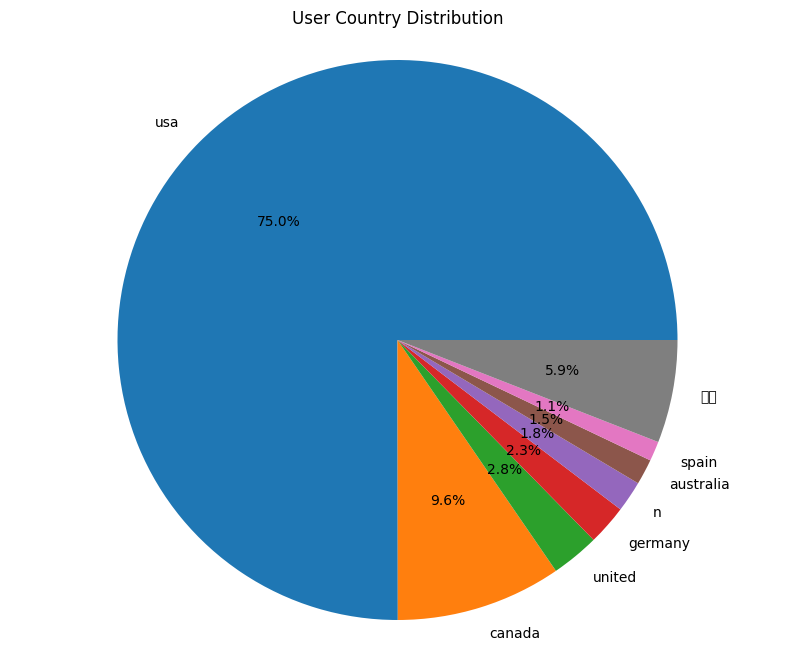

In [ ]:
country_counts = merged_data_df['User-Country'].value_counts()


country_percentages = country_counts / len(merged_data_df) * 100

selected_countries = country_percentages[country_percentages > 1]
other_countries = country_percentages[country_percentages <= 1]
other_percentage = other_countries.sum()

selected_countries['else'] = other_percentage

country_counts = merged_data_df['User-Country'].value_counts()

country_percentages = country_counts / len(merged_data_df) * 100

selected_countries = country_percentages[country_percentages > 1]
other_countries = country_percentages[country_percentages <= 1]
other_percentage = other_countries.sum()

selected_countries['其他'] = other_percentage

plt.figure(figsize=(10, 8))
plt.pie(selected_countries, labels=selected_countries.index, autopct='%1.1f%%')
plt.title('User Country Distribution')
plt.axis('equal')
plt.show()
#  we take the countirs whose occupation is larger than 1%

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 20854 (\N{CJK UNIFIED IDEOGRAPH-5176}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 20182 (\N{CJK UNIFIED IDEOGRAPH-4ED6}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


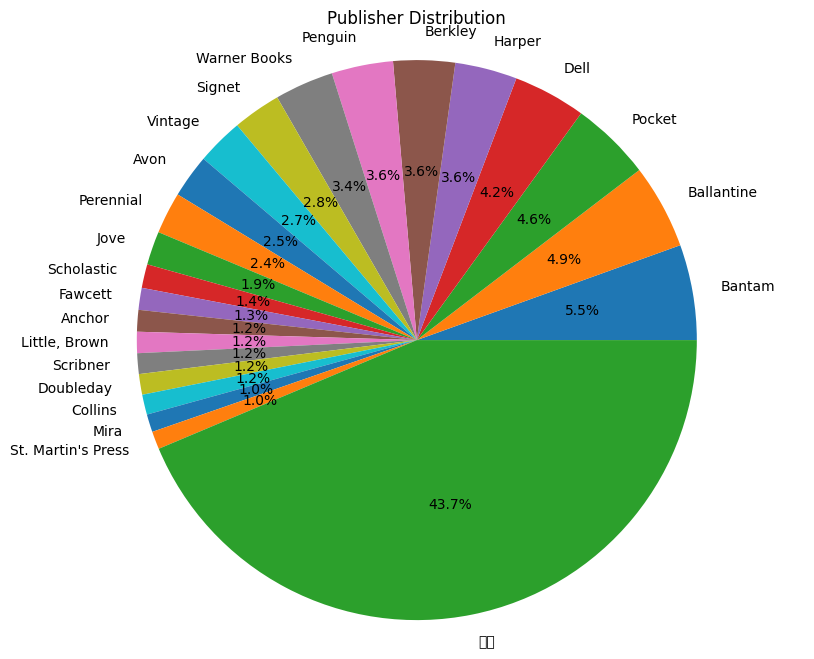

In [ ]:
publisher_counts = merged_data_df['Book-Publisher'].value_counts()


publisher_percentages = publisher_counts / len(merged_data_df) * 100

selected_publishers = publisher_percentages[publisher_percentages > 1]
other_publishers = publisher_percentages[publisher_percentages <= 1]
other_percentage = other_publishers.sum()

selected_publishers['其他'] = other_percentage


plt.figure(figsize=(10, 8))
plt.pie(selected_publishers, labels=selected_publishers.index, autopct='%1.1f%%')
plt.title('Publisher Distribution')
plt.axis('equal')
plt.show()
#  we take the publishers whose number of books is larger than 1%



Start to do Classifier/Regressor


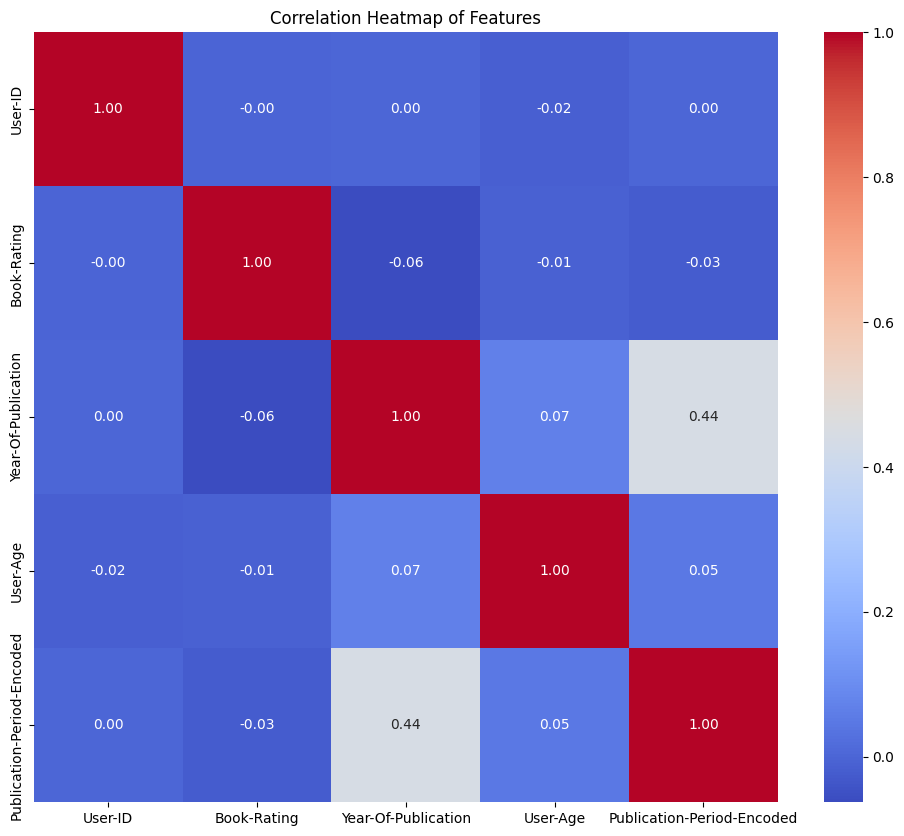

In [ ]:
def map_year_to_period(year):
    if year < 1980:
        return "Before 1980"
    elif 1980 <= year < 1990:
        return "1980s"
    elif 1990 <= year < 2000:
        return "1990s"
    elif 2000 <= year < 2010:
        return "2000s"
    elif 2010 <= year < 2020:
        return "2010s"

    else:
        return "After 2020"
merged_data_df['Publication-Period'] = merged_data_df['Year-Of-Publication'].apply(map_year_to_period)

# Divide timeline from 1960 until 2010, one decade as one period, it will be easier to analyze between each period.
period_counts = merged_data_df['Publication-Period'].value_counts()

period_counts_sorted = period_counts.sort_index()
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
merged_data_df['Publication-Period-Encoded'] = label_encoder.fit_transform(merged_data_df['Publication-Period'])
numerical_features = merged_data_df.select_dtypes(include=['int64', 'float64'])

correlation_matrix = numerical_features.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of Features')
plt.show()

# ?
modeling of publshing time

using linear regression on the relationship between user 'Publication-Period'and rating

Linear Regression RMSE: 1.7857088425545296
Linear Regression R^2 Score: 0.0007094211587113097
Linear Regression MSE: 3.1887560703774374
Linear Regression MAE: 1.4211189305601122


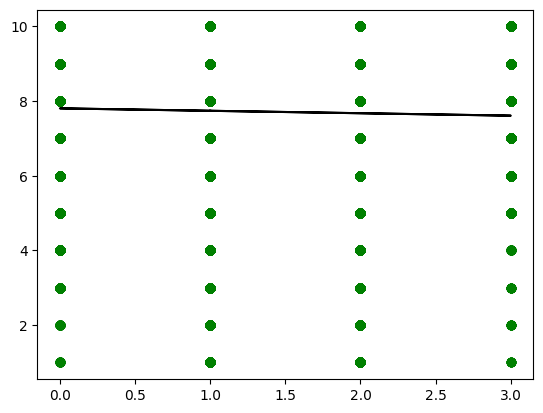

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_squared_error, mean_absolute_error

import pandas as pd

label_encoder = LabelEncoder()

merged_data_df['Publication-Period'] = label_encoder.fit_transform(merged_data_df['Publication-Period'])

X = merged_data_df[["Publication-Period"]]
y = merged_data_df['Book-Rating']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

linear_reg = LinearRegression()

linear_reg.fit(X_train, y_train)

y_pred = linear_reg.predict(X_test)

rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print("Linear Regression RMSE:", rmse)
print("Linear Regression R^2 Score:", r2)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print("Linear Regression MSE:", mse)
print("Linear Regression MAE:", mae)
# seems like the rmse and r^2 's results are not so well.

plt.scatter(X_train, y_train,color='g')
plt.plot(X_test, y_pred,color='k')

using linear regression on the relationship between user country and rating

---



In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_squared_error, mean_absolute_error

import pandas as pd

label_encoder = LabelEncoder()

merged_data_df['User-Country-Encoded'] = label_encoder_country.fit_transform(merged_data_df['User-Country'])

X = merged_data_df[['User-Country-Encoded']]
y = merged_data_df['Book-Rating']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

linear_reg = LinearRegression()

linear_reg.fit(X_train, y_train)

y_pred = linear_reg.predict(X_test)

rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print("Linear Regression RMSE:", rmse)
print("Linear Regression R^2 Score:", r2)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print("Linear Regression MSE:", mse)
print("Linear Regression MAE:", mae)
# seems like the rmse and r^2 's results are not so well.


Linear Regression RMSE: 1.78570472508233
Linear Regression R^2 Score: 0.0007140294647642875
Linear Regression MSE: 3.1887413651813596
Linear Regression MAE: 1.4204411043786669



using classification on the relationship between user country and rating (dvivding rating into 3 degrees)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder

# Encode User-Country column into numerical form
label_encoder_country = LabelEncoder()
merged_data_df['User-Country-Encoded'] = label_encoder_country.fit_transform(merged_data_df['User-Country'])

# Define features
X = merged_data_df[['Publication-Period', 'User-Country-Encoded']]
# Define target variable
y = merged_data_df['Book-Rating']

# Define the categories for rating classification
def classify_rating(rating):
    if rating <= 5:
        return 'Low'
    elif rating <= 7:
        return 'Medium'
    else:
        return 'High'

# Create a new target variable with rating categories
y_classification = y.apply(classify_rating)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_classification, test_size=0.2, random_state=42)

# Initialize and train the logistic regression model
logistic_reg = LogisticRegression(max_iter=1000)
logistic_reg.fit(X_train, y_train)

# Predict rating categories for test set
y_pred = logistic_reg.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)

# Print accuracy
print("Classification Accuracy:", accuracy)

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Accuracy: 0.6091886464379301
Classification Report:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

        High       0.61      1.00      0.76     24875
         Low       0.00      0.00      0.00      5626
      Medium       0.00      0.00      0.00     10332

    accuracy                           0.61     40833
   macro avg       0.20      0.33      0.25     40833
weighted avg       0.37      0.61      0.46     40833



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# ?

Accuracy: {'Accuracy': [0.43173413660519677]}
Linear Regression RMSE: 1.3590838664304266
Linear Regression R^2 Score: -0.9544758872077932
Linear Regression MSE: 1.8471089559914775
Linear Regression MAE: 0.9877550020816497


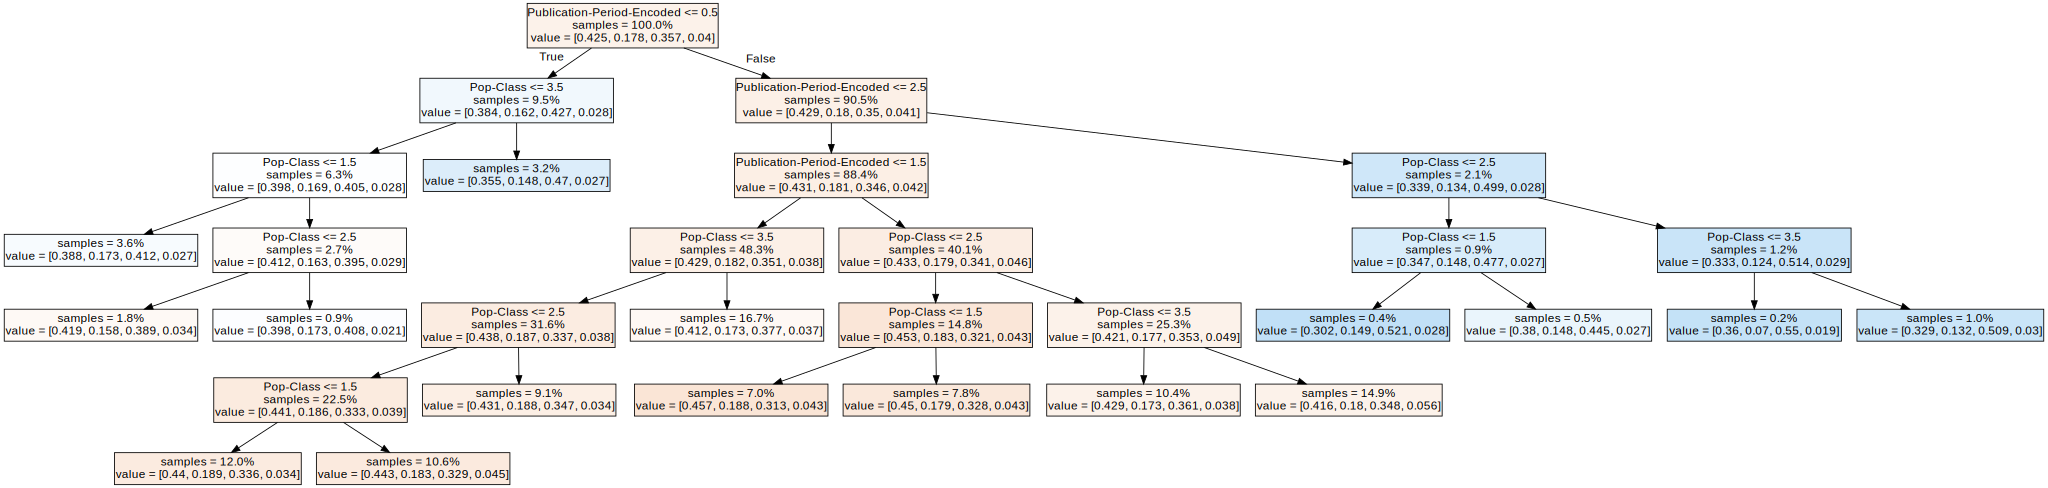

In [ ]:
# Random Forest Attempt --- https://www.datacamp.com/tutorial/random-forests-classifier-python

# Data Processing
import pandas as pd
import numpy as np

# Modelling
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint

# Tree Visualisation
from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
merged_data_df["Pub-Encoded"] = label_encoder.fit_transform(merged_data_df["Book-Publisher"])

top_half_pub = []
sorted_pub = merged_data_df["Book-Publisher"].value_counts().index
pub_read = merged_data_df["Book-Publisher"].value_counts().values

min = 0
a = 1
i=0
pop_class = [1, 2, 3, 4, 5]
curr_prog = 0

for i in range(len(sorted_pub)):
    pub_pop = (sum(pub_read[0: i])/merged_data_df.shape[0])
    if (pub_pop >= 0.5):
        break
    top_half_pub.append(sorted_pub[i])

merged_data_df["In-Most-Read-Pub"] = merged_data_df["Book-Publisher"].isin(top_half_pub)

i=0
while (curr_prog < 100):
    curr_lst = []
    while (a <= len(pub_read)):
        pub_pop = (sum(pub_read[min: a-1])/merged_data_df.shape[0])

        if (i == 3):
            curr_lst = sorted_pub[min: len(pub_read)]
            merged_data_df.loc[merged_data_df["Book-Publisher"].isin(curr_lst), "Pop-Class"] = pop_class[i]
            curr_prog = 100
            break


        if (pub_pop > 0.20):
            curr_lst = sorted_pub[min: a-1]
            merged_data_df.loc[merged_data_df["Book-Publisher"].isin(curr_lst), "Pop-Class"] = pop_class[i]
            i += 1
            min = a-1
            curr_prog += pub_pop
            break

        a+=1


book_rating_class = ["Low", "Medium", "High", "Very High"]
merged_data_df.loc[merged_data_df["Book-Rating"] <= 4, "Book-Rating-Class"] = "Very Low"
merged_data_df.loc[(merged_data_df["Book-Rating"] >= 5) & (merged_data_df["Book-Rating"] <= 6), "Book-Rating-Class"] = "Medium"
merged_data_df.loc[(merged_data_df["Book-Rating"] >= 7) & (merged_data_df["Book-Rating"] <= 8), "Book-Rating-Class"] = "High"
merged_data_df.loc[(merged_data_df["Book-Rating"] >= 9) & (merged_data_df["Book-Rating"] <= 10), "Book-Rating-Class"] = "Very High"


b = []
ind = []
d={}
a = 0

for i in range(1):
    X = merged_data_df[["Pop-Class", "Publication-Period-Encoded"]]
    y = merged_data_df["Book-Rating-Class"]

    # Split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)


    rf = RandomForestClassifier()
    rf.fit(X_train, y_train)

    y_pred = rf.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)

    if (a == 10):
      break
    a += 1

    b.append(accuracy)
    ind.append(i)

d = {"Accuracy":b}
print("Accuracy:",d)

# Export the first three decision trees from the forest
y_test = label_encoder.fit_transform(y_test)
y_pred = label_encoder.fit_transform(y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print("Linear Regression RMSE:", rmse)
print("Linear Regression R^2 Score:", r2)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print("Linear Regression MSE:", mse)
print("Linear Regression MAE:", mae)




for i in range(1):
    tree = rf.estimators_[i]
    dot_data = export_graphviz(tree,
                               feature_names=X_train.columns,
                               filled=True,

                               impurity=False,
                               proportion=True)
    graph = graphviz.Source(dot_data)
    display(graph)

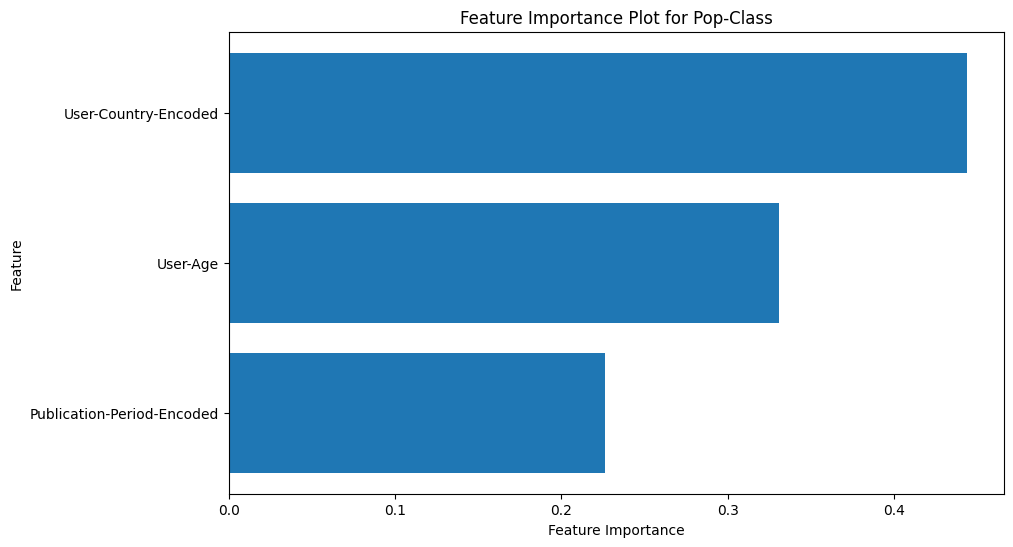

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Make a copy of X
X_with_new_features = X.copy()

# Encode User-Country column into numerical form
label_encoder_country = LabelEncoder()
X_with_new_features["User-Country-Encoded"] = label_encoder_country.fit_transform(merged_data_df["User-Country"])

# Remove the original "User-Country" column
X_with_new_features.drop("User-Country", axis=1, inplace=True)

# Train the decision tree regressor
dt_reg.fit(X_with_new_features, y)

# Get feature importances
feature_importances = dt_reg.feature_importances_

# Get feature names
feature_names = X_with_new_features.columns

# Sort feature indices based on importance
sorted_idx = np.argsort(feature_importances)

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_idx)), feature_importances[sorted_idx])
plt.yticks(range(len(sorted_idx)), [feature_names[i] for i in sorted_idx])
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importance Plot for Pop-Class')
plt.show()

### please do not delete this section

In [ ]:
# Merge Ratings on Books to insert book titles
book_ratings_df = pd.merge(ratings_df, books_df, on='ISBN', how='left')

# Group by the titles and calculate the number and the mean
book_ratings_df = book_ratings_df.groupby('Book-Title').agg(
    Total_Ratings=('Rating', 'count'),
    Average_Rating=('Rating', 'mean')).reset_index()

# Count the number of occurrences for each rating score
rating_distribution = ratings_df['Rating'].value_counts().sort_index()

# Convert it to a DataFrame
rating_distribution_df = pd.DataFrame({
    'Rating': rating_distribution.index,
    'Count': rating_distribution.values
})

# Merge them together
merged_ratings_df = pd.merge(book_ratings_df, rating_distribution_df,
                             on='Rating', how='outer')

# Fill any missing values with 0
merged_ratings_df.fillna(0, inplace=True)

# Sort it in descending order
merged_ratings_df = merged_ratings_df.sort_values('Total_Ratings',
                                                  ascending=False)

In [ ]:
# Plot the distribution of ratings
plt.figure(figsize=(12, 6))
sns.barplot(merged_ratings_df, x = 'Rating', y = 'Count')
plt.xlabel('Rating Score')
plt.ylabel('Number of Ratings')
plt.title('Rating Distribution')
plt.show()

In [ ]:
# Plot the top 10 books using the average scores
sns.bar()
plt.title('Distribution of Top 10 Books')
plt.xlabel('Average Rating')
plt.ylabel('Density')
plt.show()

In [ ]:
#
plt.figure(figsize=(12, 6))
sns.barplot(top_books, x='ISBN', y='Number of Ratings')
plt.title('')
plt.xlabel('ISBN')
plt.ylabel('Number of Ratings')
plt.xticks(rotation=45)
plt.show()

#### Using KNN

using decision tree to plot a extra graph showing about importance of each feature for rating